## Second Lab

What we are going to do today:
- Recap of the previous Lab
- Define the nearest neighbor method and use it
- Define the Best Nearest Neighbors and use it 
- Define the Multi Fragment and use it
- Finally compare these Constructive Methods

This cell below is simply importing some useful stuff for later

In [1]:
import glob
import numpy as np
from matplotlib import pyplot as plt

from time import time as t

## Recap
### The problems
As we saw last time, we have 12 problems and two have an optimal solution

In [2]:
problems = glob.glob('../problems/*.tsp')
for prob in problems:
    if prob in ["../problems/eil76.tsp", "../problems/kroA100.tsp"]:
        print(f"- {prob[12:]} with opt", sep='\t')
    else:
        print(f"- {prob[12:]}", sep='\t')

- ch130.tsp
- d198.tsp
- eil76.tsp
- fl1577.tsp
- kroA100.tsp
- lin318.tsp
- pcb442.tsp
- pr439.tsp
- rat783.tsp
- u1060.tsp


#### ProblemInstance Class
Last time we implemented an ProblemInstance class that we can use to load a problem. 

In [3]:
from src.io_tsp import ProblemInstance



#############################
name: eil76
nPoints: 76
best_sol: 538.0
exist optimal: True


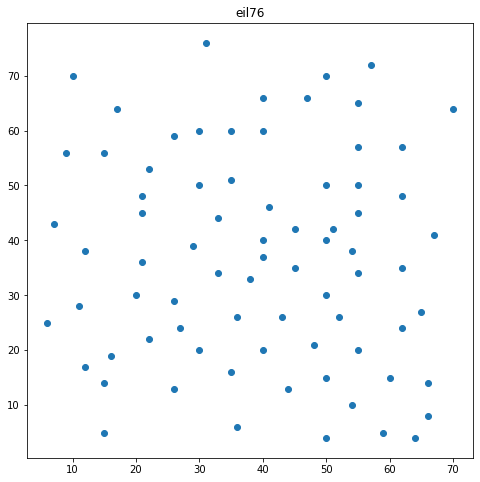

[[ 0. 15. 23. ... 18. 23. 25.]
 [15.  0. 24. ...  7. 12. 15.]
 [23. 24.  0. ... 31. 21. 20.]
 ...
 [18.  7. 31. ...  0. 17. 20.]
 [23. 12. 21. ... 17.  0.  3.]
 [25. 15. 20. ... 20.  3.  0.]]


In [6]:
example_problem = "../problems/eil76.tsp"
p_inst = ProblemInstance(example_problem)
p_inst.print_info()
p_inst.plot_data()
print(p_inst.dist_matrix)

### TSPSolver Class
Even here, instead of reimplementing the class everytime, we can import the one I prepared before.
This implementation is ready to receive a lot of different types of problems

In [4]:
from src.TSP_solver import TSPSolver
from src.constructive_algorithms import random_method

The class implements the following methods:
...

###  solving with ['random'] ####


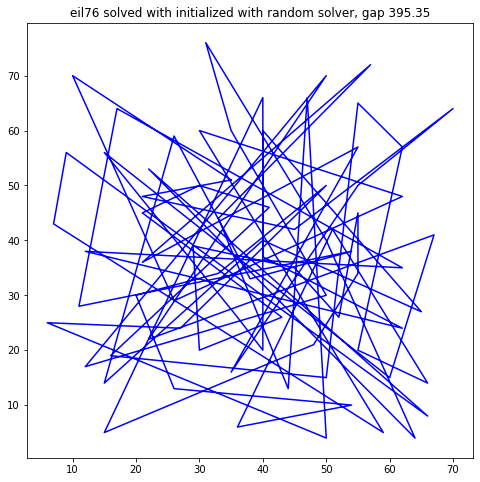

best solution with len 2665.0 
with a total time of 0.0 seconds


In [7]:
available_solvers = {"random": random_method}

solver = TSPSolver("random", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Let's analyse the performances of the random Method


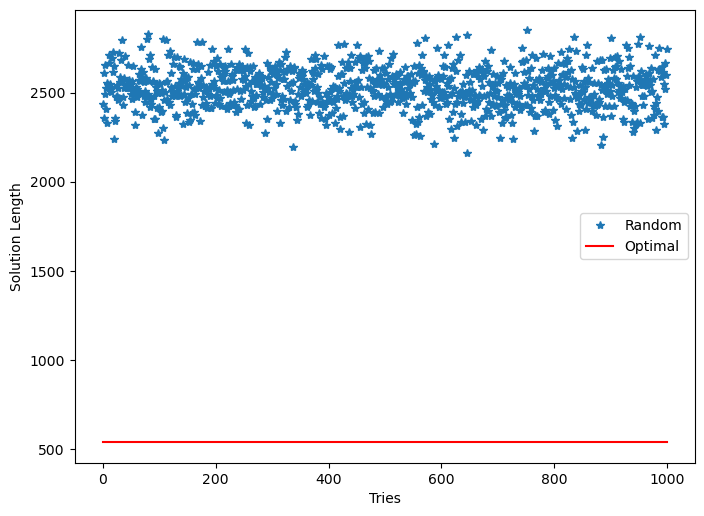

best solution 2160.0 on 1000 trials,
with a total time of 0.59 seconds


In [8]:
number_of_trials = 1000
found_lens = []
start = t()
for _ in range(number_of_trials):
    solver.compute_solution(return_value=False, verbose=False)
    found_lens.append(solver.found_length)
end = t()
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.ylabel("Solution Length")
plt.xlabel("Tries")
plt.plot(found_lens, "*",label="Random")
plt.plot(np.ones(number_of_trials)*p_inst.best_sol, "r-",label="Optimal")
plt.legend(loc="center right")
plt.show()

print(f"best solution {min(found_lens)} on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

-------------
## Constructive Algorithm
### Nearest Neighbor Method

In [9]:
def alessio_marco_nn(instance_, starting_node=0): 
    # TODO
    tour=[starting_node]
    for i in range(instance_.nPoints):
        next_node = np.argsort(instance_.dist_matrix[i])[0]
        index=0
        while next_node in tour:
            index+=1
            if index<instance_.nPoints:
                next_node = np.argsort(instance_.dist_matrix[i])[index]
            else:
                break
        tour.append(next_node)
    # [...]
    tour.append(starting_node)
    return np.array(tour) 

def nn( instance_, starting_node=0): 
    # TODO
    dist_matrix = np.copy(instance_.dist_matrix)
    n = int(instance_.nPoints)
    node = starting_node
    tour = [node]
    # Suggestion ^^^^
    for _ in range(n - 1):
        for new_node in np.argsort(dist_matrix[node]):
              if new_node not in tour:
                    tour.append(new_node)
                    node = new_node
                    break
    # [...]
    tour.append(starting_node)
    return np.array(tour)

###  solving with ['nn'] ####


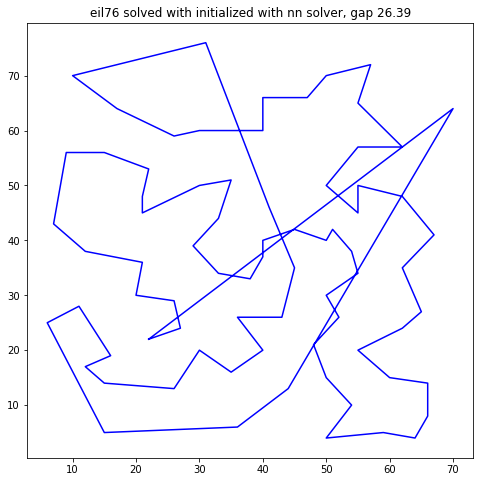

best solution with len 680.0 
with a total time of 0.0378 seconds


In [10]:
available_solvers = {"random": random_method,
                     "amnn":alessio_marco_nn,
                    "nn":nn}

solver = TSPSolver("nn", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Best Nearest Neighbors

In [10]:
def best_nn(instance):
    # TODO
   
    # [...]
    return solution


###  solving with ['best_nn'] ####


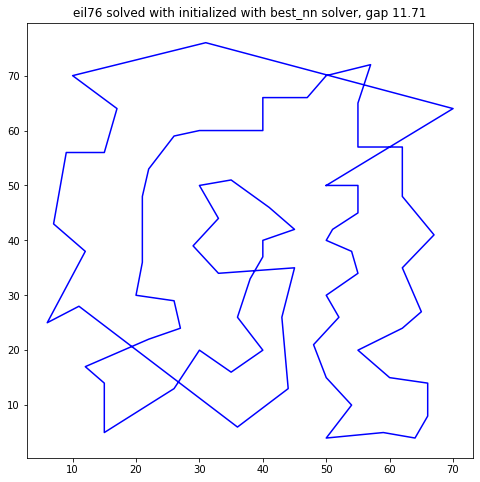

best solution with len 601.0 
with a total time of 0.05389 seconds


In [11]:
available_solvers = {"random": random_method,
                     "nn": nn,
                     "best_nn": best_nn}

solver = TSPSolver("best_nn", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Multi Fragment

In [12]:
def check_if_edge_available(n1, n2, sol):
    return (len(sol[str(n1)]) < 2) and (len(sol[str(n2)]) < 2)

def check_if_not_close(edge_to_append, sol):
    n1, n2 = edge_to_append
    from_city = n2
    if len(sol[str(from_city)]) == 0:
        return True
    partial_tour = [from_city]
    iter_num = 0
    while True:
        if len(sol[str(from_city)]) == 1:
            if from_city == n1:
                return_value = False
                break
            elif iter_num > 1:
                return_value = True
                break
            else:
                from_city = sol[str(from_city)][0]
                partial_tour.append(from_city)
                iter_num += 1
        else:
            for node_connected in sol[str(from_city)]:
                if node_connected not in partial_tour:
                    from_city = node_connected
                    partial_tour.append(node_connected)
                    iter_num +=1
    return return_value

def create_solution(start_sol, sol):
    assert len(start_sol)==2, "too many cities with just one link"
    n1, n2 = start_sol
    from_city = n2
    sol_list = [n1, n2]
    iter_num = 0
    while iter_num <300:
        for node_connected in sol[str(from_city)]:
            iter_num += 1
            if node_connected not in sol_list:
                from_city = node_connected
                sol_list.append(node_connected)
    sol_list.append(n1)
    return sol_list

def mf(instance):
    mat = np.copy(instance.dist_matrix)
    mat = np.triu(mat)
    mat[mat == 0] = 100000
    # TODO
   
    #[...]
    return create_solution(start_list, solution)




###  solving with ['multi_fragment'] ####


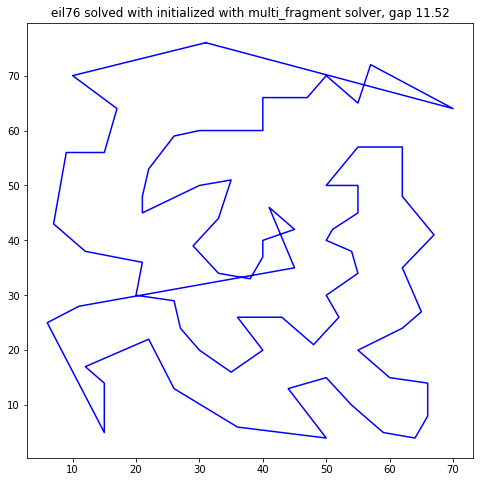

best solution with len 600.0 
with a total time of 0.00597 seconds


In [13]:
available_solvers = {"random": random_method,
                     "nn":nn,
                     "best_nn":best_nn,
                     "multi_fragment": mf
                    }

solver = TSPSolver("multi_fragment", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

### Comparison Constructive methods

In [23]:
from time import time as t
import pandas as pd
from tqdm import tqdm

available_solvers = {"random": random_method,
                     "nn":nn,
                     "best_nn":best_nn,
                     "multi_fragment": mf
                    }

show_plots = False
verbose = False
problems = ["../problems/eil76.tsp", "../problems/kroA100.tsp", "../problems/ch130.tsp", "../problems/d198.tsp"]
methods = available_solvers.keys()
results = []
index = []
with tqdm(problems) as tq:
    for filename in tq:
        p_inst = ProblemInstance(filename)
        if verbose:
            print("\n\n#############################")
            p_inst.print_info()
        if show_plots:
            p_inst.plot_data()

        for method in methods:
            tq.set_postfix_str(f"using {method} for {p_inst.name}")
            solver = TSPSolver(method, p_inst, available_solvers)
            start = t()
            solver.compute_solution(return_value=False, verbose=verbose)
            end = t()
            if verbose:   
                print(f"the total length for the solution found is {solver.found_length}",
                        f"while the optimal length is {p_inst.best_sol}",
                        f"the gap is {solver.gap} %",
                        f"the solution is found in {np.round(end - start, 5)} seconds",sep="\n")
            index.append((filename[12:], method))
            results.append([solver.found_length, p_inst.best_sol, solver.gap, end - start])

            if show_plots:
                  solver.plot_solution()

            if p_inst.exist_opt and show_plots:
                solver = TSPSolver("optimal", p_inst)
                solver.solved = True
                solver.solution = np.concatenate([p_inst.optimal_tour, [p_inst.optimal_tour[0]]])
                solver.plot_solution()


100%|██████████| 4/4 [00:01<00:00,  2.94it/s, using multi_fragment for d198]   


In [24]:
index = pd.MultiIndex.from_tuples(index, names=['problem', 'method'])

df = pd.DataFrame(results, index=index, columns=["tour length", "optimal solution", "gap", "time to solve"])
df

tour length  optimal solution      gap  \
problem     method                                                   
eil76.tsp   random               2616.0             538.0   386.25   
            nn                    680.0             538.0    26.39   
            best_nn               601.0             538.0    11.71   
            multi_fragment        600.0             538.0    11.52   
kroA100.tsp random             163891.0           21282.0   670.09   
            nn                  27807.0           21282.0    30.66   
            best_nn             24815.0           21282.0    16.60   
            multi_fragment      24287.0           21282.0    14.12   
ch130.tsp   random              44209.0            6110.0   623.55   
            nn                   7578.0            6110.0    24.03   
            best_nn              6880.0            6110.0    12.60   
            multi_fragment       7849.0            6110.0    28.46   
d198.tsp    random             188837.0           15780.0  1096.69   
            nn                  18975.0           15780.0    20.25   
            best_nn             17565.0           15780.0    11.31   
            multi_fragment      17111.0           15780.0     8.43   

                            time to solve  
problem     method                         
eil76.tsp   random               0.000970  
            nn                   0.000997  
            best_nn              0.049906  
            multi_fragment       0.005983  
kroA100.tsp random               0.001030  
            nn                   0.001961  
            best_nn              0.101760  
            multi_fragment       0.007005  
ch130.tsp   random               0.001029  
            nn                   0.002980  
            best_nn              0.206479  
            multi_fragment       0.017952  
d198.tsp    random               0.001047  
            nn                   0.005039  
            best_nn              0.694035  
            multi_fragment       0.065004